In [219]:
from __future__ import division
from dbhelper import get_crossings, pd_query
from modelhelper import cvfolds
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV

In [65]:
query = '''
        select 
            c.date,
            waittime,
            year,
            month,
            dayofmonth,
            week,
            dayofweek,
            EXTRACT(MINUTE FROM time - '00:00:00'::time) + 60 * EXTRACT(HOUR FROM time - '00:00:00'::time) minofday
        from crossingdata c
        join datefeatures d on c.date = d.date
        where
            valid=1
            and waittime is not null
            and crossing_id = %s
        order by c.date
        '''

df = pd_query(query, (1))

In [66]:
cv = cvfolds(df)

### Run a single test for last 3 years

In [79]:
model = RandomForestRegressor(n_jobs=-1, n_estimators=100)

In [68]:
X = df.copy()
y = X.pop('waittime')
X = X.drop('date', axis=1)

In [69]:
X.head()

,year,month,dayofmonth,week,dayofweek,minofday
0,2007,1,1,1,0,0
1,2007,1,1,1,0,5
2,2007,1,1,1,0,10
3,2007,1,1,1,0,15
4,2007,1,1,1,0,20


In [70]:
X_train = np.array(X)[cv[6][0]]
y_train = np.array(y)[cv[6][0]]
X_test = np.array(X)[cv[6][1]]
y_test = np.array(y)[cv[6][1]]

In [80]:
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [81]:
model.score(X_test, y_test)

-0.12035043609075258

In [82]:
yhat = model.predict(X_test)

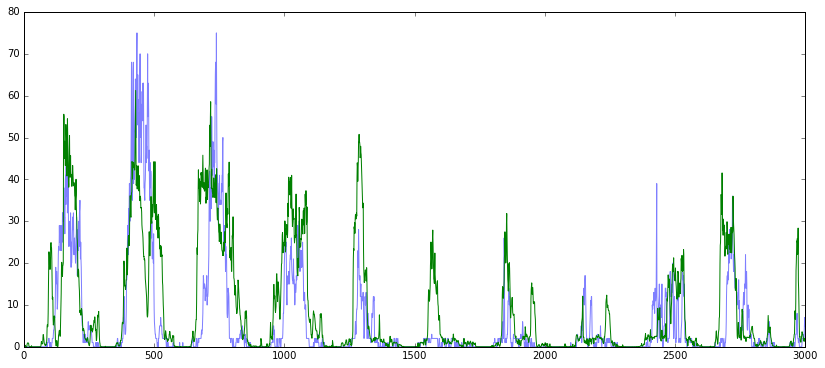

In [89]:
plt.figure(figsize=(14,6))
plt.plot(y_test[:3000], color='b', alpha=.5)
plt.plot(yhat[:3000], color='g');

Negative R^2 is poor, but at least for this restricted data set, the daily seasonality is evident.

Time to run with all data

In [232]:
model = RandomForestRegressor(n_jobs=-1)
params = {'n_estimators': [50]}
grid = GridSearchCV(model, params, cv=cv[:-1], n_jobs=-1)   # last cv set (2015) is holdout set

In [233]:
X = df.copy()
y = X.pop('waittime')
X = X.drop('date', axis=1)

In [234]:
grid.fit(X, y)

GridSearchCV(cv=[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, ...8, 735839, 735840, 735841, 735842, 735843, 735844, 735845, 735846, 735847, 735848, 735849, 735850])],
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=-1,
       param_grid={'n_estimators': [50]}, pre_dispatch='2*n_jobs',
       refit=True, score_func=None, scoring=None, verbose=0)

In [235]:
grid.best_score_

0.093145814084250045

R^2 is worse.  Unexpected.

In [236]:
X_test = np.array(X)[cv[6][1]]
y_test = np.array(y)[cv[6][1]]

In [237]:
y_hat = grid.predict(X_test)

In [238]:
grid.score(X_test, y_test)

0.99298665186881208

In [239]:
df_predict = df[df.date >= '1/1/15'].copy()

In [240]:
df_predict['prediction'] = y_hat

In [241]:
df_predict.set_index('date', inplace=True)

In [242]:
def plot_waittimes(df, field, start, end):
    df[((df.index >= start) & (df.index < end))][['waittime', field]].plot(figsize=(14,6));

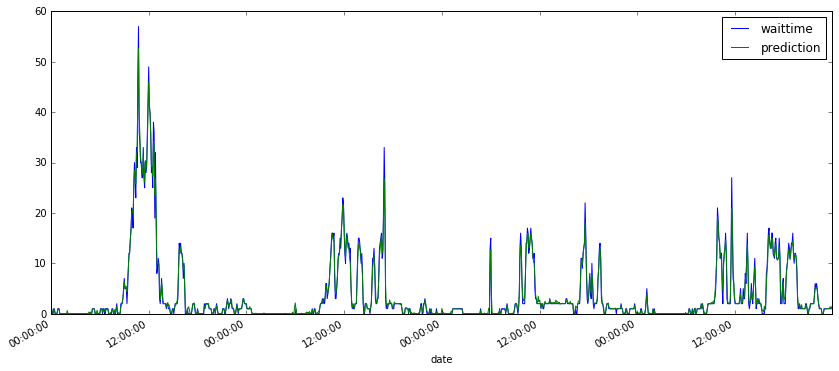

In [243]:
plot_waittimes(df_predict, 'prediction', '6/1/15', '6/5/15')

### Clearly 2015 data leaked into model

In [155]:
X_test = np.array(X)[cv[6][1]]
y_test = np.array(y)[cv[6][1]]
X_train = np.delete(np.array(X), cv[6][1], 0)
y_train = np.delete(np.array(y), cv[6][1], 0)

In [156]:
print X.shape
print X_test.shape
print X_train.shape

(829171, 6)
(93320, 6)
(735851, 6)


In [157]:
model = RandomForestRegressor(n_jobs=-1)
params = {'n_estimators': [50]}
grid = GridSearchCV(model, params, cv=cv[:-1], n_jobs=-1)   # last cv set (2015) is holdout set

In [170]:
grid.fit(X_train, y_train)
grid.best_score_

0.097640830980327123

In [171]:
y_hat = grid.predict(X_test)
grid.score(X_test, y_test)

-0.12165036475803026

In [172]:
df_predict = df[df.date >= '1/1/15'].copy()
df_predict.set_index('date', inplace=True)

In [173]:
df_predict['prediction'] = y_hat

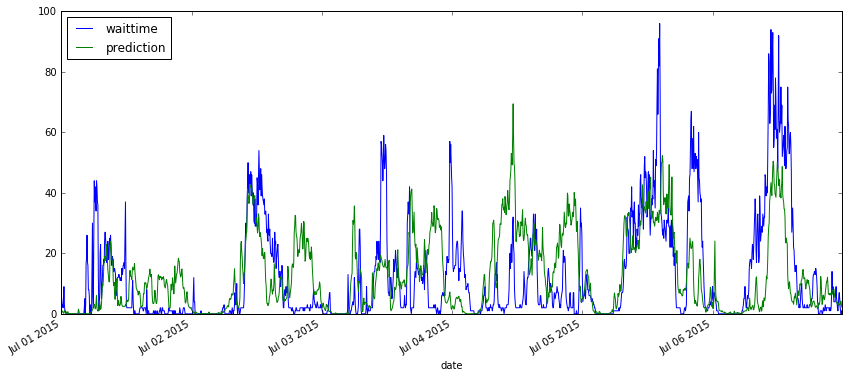

In [218]:
plot_waittimes(df_predict, 'prediction', '7/1/15', '7/7/15')

## Next steps
* Is volume more predictable?  Can we then predict volume, then predict wait time from predicted volume?
* Is this prediction any better than average by day of week in past year?  **NO**
* Is prediction better with more years of trained data, e.g. 3 years instead of 2 years?
* Does smoothing improve the prediction?

In [182]:
summ2014 = df[df.year==2014].groupby(['dayofweek', 'minofday']).waittime.mean()

In [201]:
summ2014 = pd.DataFrame(summ2014)
summ2014.columns = ['wt_2014']
summ2014 = summ2014.reset_index()

In [202]:
df_predict.head()

,waittime,year,month,dayofmonth,week,dayofweek,minofday,prediction
date,,,,,,,,
2015-01-01 00:00:00,0,2015,1,1,1,3,0,0.02
2015-01-01 00:05:00,0,2015,1,1,1,3,5,0.04
2015-01-01 00:10:00,0,2015,1,1,1,3,10,0.04
2015-01-01 00:15:00,0,2015,1,1,1,3,15,0.02
2015-01-01 00:20:00,0,2015,1,1,1,3,20,0.06


In [207]:
dow = df_predict.reset_index().merge(summ2014, on=['dayofweek', 'minofday']).set_index('date')

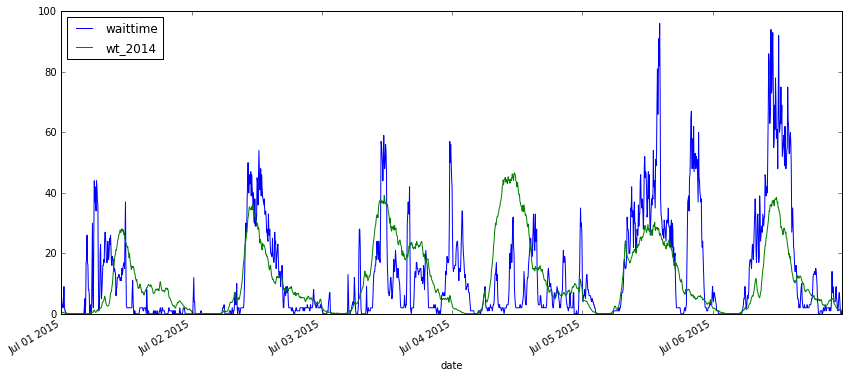

In [217]:
plot_waittimes(dow, 'wt_2014', '7/1/15', '7/7/15')

In [231]:
from sklearn.metrics import r2_score

print r2_score(dow.waittime, dow.wt_2014)
print r2_score(dow.waittime, dow.prediction)

0.143442299388
-0.121650364758


## Random Forest is worse than average by day of week
Need to evaluate whether this is the case for all years, e.g. compare prediction for year Y for all Y for:
1. average by day of week for Y-1
2. RF model using Y-2, Y-1